In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import terminalLogic
from terminalLogic import Algo
import client
from client import engine
from typing import Optional, Dict, Any, List
from ciso8601 import parse_datetime
from requests import Request, Session, Response
import sys
import hmac
import urllib.parse
import time
import plotly.graph_objects as go
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime
plt.rcParams["figure.figsize"] = (100,10)


In [2]:
df = engine.getData('BTCPERP')
df

,time,open,high,low,close,volume
0,2021-10-30 18:02:00,61435.0,61441.0,61435.0,61438.0,7341.8207
1,2021-10-30 18:03:00,61440.0,61473.0,61439.0,61471.0,358767.1945
2,2021-10-30 18:04:00,61471.0,61511.0,61470.0,61511.0,203094.7563
3,2021-10-30 18:05:00,61511.0,61514.0,61510.0,61513.0,29691.7707
4,2021-10-30 18:06:00,61513.0,61519.0,61490.0,61519.0,430331.3314
...,...,...,...,...,...,...
1495,2021-10-31 18:57:00,60724.0,60748.0,60723.0,60740.0,23171.0027
1496,2021-10-31 18:58:00,60740.0,60813.0,60740.0,60807.0,50930.8972
1497,2021-10-31 18:59:00,60807.0,60807.0,60744.0,60752.0,40381.7170
1498,2021-10-31 19:00:00,60754.0,60811.0,60754.0,60802.0,51792.4581


In [3]:
df.tail(10)
df = df[::-1]
df

,time,open,high,low,close,volume
1499,2021-10-31 19:01:00,60801.0,60827.0,60801.0,60827.0,57513.3469
1498,2021-10-31 19:00:00,60754.0,60811.0,60754.0,60802.0,51792.4581
1497,2021-10-31 18:59:00,60807.0,60807.0,60744.0,60752.0,40381.7170
1496,2021-10-31 18:58:00,60740.0,60813.0,60740.0,60807.0,50930.8972
1495,2021-10-31 18:57:00,60724.0,60748.0,60723.0,60740.0,23171.0027
...,...,...,...,...,...,...
4,2021-10-30 18:06:00,61513.0,61519.0,61490.0,61519.0,430331.3314
3,2021-10-30 18:05:00,61511.0,61514.0,61510.0,61513.0,29691.7707
2,2021-10-30 18:04:00,61471.0,61511.0,61470.0,61511.0,203094.7563
1,2021-10-30 18:03:00,61440.0,61473.0,61439.0,61471.0,358767.1945


## mean rev algo

In [4]:
ma = 30
# calc rate ofreturn close to close
df['returns'] = np.log(df["close"]).diff()
# add column to keep track of mean or moving average
df['ma'] = df['close'].rolling(ma).mean()
# to decide when too far away from mean add column called ratio
df['ratio'] = df['close'] / df['ma']
# create variable for price points that might work
percentiles = [5, 10, 50, 90, 95]
# get a look at where percentiles are w numpy percential function on btc ratio column
np.percentile(df['ratio'].dropna(), percentiles)
p = np.percentile(df['ratio'].dropna(), percentiles)

<ipython-input-4-8dee82ff3630>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns'] = np.log(df["close"]).diff()
<ipython-input-4-8dee82ff3630>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ma'] = df['close'].rolling(ma).mean()
<ipython-input-4-8dee82ff3630>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [5]:
# Define place where we short at 95th percentile and long at 5th
short = p[-1]
long = p[0]
# use np.where which is numpys version of excels 'if' function
# add column to df for position value
# look at ratio column -1 indicates short otherwise nan
df['position'] = np.where(df.ratio > short, -1, np.nan)
# when long position at 1 instead of np.nan we leave btc['position'] where it is.
df['position'] = np.where(df.ratio < long, 1, df['position'])
# This strat isnt neutral, its always in a long or short.
df['position'] = df['position'].ffill()
df['strat_return'] = df['returns'] * df['position'].shift()

<ipython-input-5-d79d4d1526db>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'] = np.where(df.ratio > short, -1, np.nan)
<ipython-input-5-d79d4d1526db>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'] = np.where(df.ratio < long, 1, df['position'])
<ipython-input-5-d79d4d1526db>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

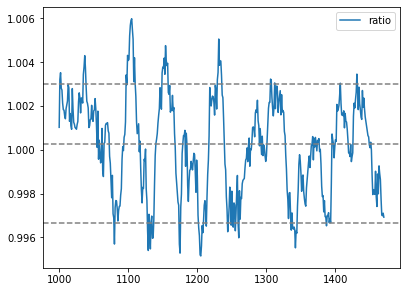

In [6]:
# visual look at ratio column
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

df['ratio'].head(500).dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--');
# can see ratio move around mean

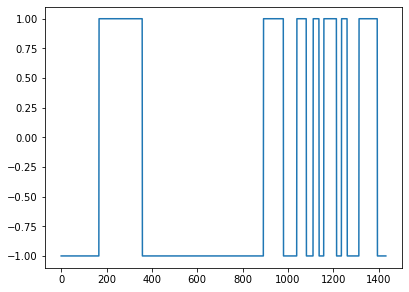

In [7]:
# df.position.dropna().plot()
plt.plot(df.head(2500).position.dropna())
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


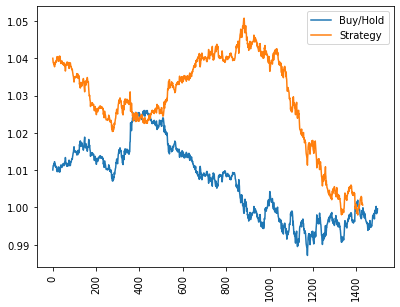

In [8]:
plt.plot(np.exp(df['returns'].dropna()).cumprod(), label='Buy/Hold')
plt.plot(np.exp(df['strat_return'].dropna()).cumprod(), label='Strategy')
plt.xticks(rotation=90)
plt.legend();

In [9]:
df['min_ret'] = df['close']/df['close'].shift(1)-1
df['pct_min_ret'] = df['close'].pct_change(1)
df['min_ret_log'] = np.log(df['close']/df['close'].shift(1))
df['cumret'] = np.cumsum(df['min_ret'])
df['strat_cumret'] = df['min_ret'] * df['position'].shift()
print("Market cumulative returns: ", df['cumret'].iloc[-1])
print("Strategy Cumulative Returns: ", df['strat_cumret'].iloc[-1])

Market cumulative returns:  0.010329946555143077
Strategy Cumulative Returns:  0.0005368385092157091


<ipython-input-9-50d514336f32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['min_ret'] = df['close']/df['close'].shift(1)-1
<ipython-input-9-50d514336f32>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pct_min_ret'] = df['close'].pct_change(1)
<ipython-input-9-50d514336f32>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [10]:
df['min_retmark'] = df['close'].pct_change()
cum_retmark = (df.min_retmark + 1).cumprod()*1000
#df['strat_ret'] = df['min_retmark'] * df['position'].shift(1)-1
cum_retmark.iloc[-1]

<ipython-input-10-fb64a7465d7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['min_retmark'] = df['close'].pct_change()


1010.044881384911

In [11]:
df['goodTrades'] = np.where((df.strat_return / df.close) * .15 > df.returns / df.close, 1, np.nan)
df['goodTrades'] = np.where((df.strat_return / df.close)* .15 < df.returns / df.close, 0, df['goodTrades'])
df = df.drop("time", axis=1)
df

<ipython-input-11-b76367066649>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goodTrades'] = np.where((df.strat_return / df.close) * .15 > df.returns / df.close, 1, np.nan)
<ipython-input-11-b76367066649>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goodTrades'] = np.where((df.strat_return / df.close)* .15 < df.returns / df.close, 0, df['goodTrades'])


,open,high,low,close,volume,returns,ma,ratio,position,strat_return,min_ret,pct_min_ret,min_ret_log,cumret,strat_cumret,min_retmark,goodTrades
1499,60801.0,60827.0,60801.0,60827.0,57513.3469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,60754.0,60811.0,60754.0,60802.0,51792.4581,-0.000411,NaN,NaN,NaN,NaN,-0.000411,-0.000411,-0.000411,-0.000411,NaN,-0.000411,NaN
1497,60807.0,60807.0,60744.0,60752.0,40381.7170,-0.000823,NaN,NaN,NaN,NaN,-0.000822,-0.000822,-0.000823,-0.001233,NaN,-0.000822,NaN
1496,60740.0,60813.0,60740.0,60807.0,50930.8972,0.000905,NaN,NaN,NaN,NaN,0.000905,0.000905,0.000905,-0.000328,NaN,0.000905,NaN
1495,60724.0,60748.0,60723.0,60740.0,23171.0027,-0.001102,NaN,NaN,NaN,NaN,-0.001102,-0.001102,-0.001102,-0.001430,NaN,-0.001102,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,61513.0,61519.0,61490.0,61519.0,430331.3314,-0.000325,61474.100000,1.000730,-1.0,0.000325,-0.000325,-0.000325,-0.000325,0.011647,0.000325,-0.000325,1.0
3,61511.0,61514.0,61510.0,61513.0,29691.7707,-0.000098,61477.000000,1.000586,-1.0,0.000098,-0.000098,-0.000098,-0.000098,0.011550,0.000098,-0.000098,1.0
2,61471.0,61511.0,61470.0,61511.0,203094.7563,-0.000033,61480.600000,1.000494,-1.0,0.000033,-0.000033,-0.000033,-0.000033,0.011517,0.000033,-0.000033,1.0
1,61440.0,61473.0,61439.0,61471.0,358767.1945,-0.000651,61482.866667,0.999807,-1.0,0.000651,-0.000650,-0.000650,-0.000651,0.010867,0.000650,-0.000650,1.0


In [12]:
print(df['goodTrades'].value_counts())

0.0    728
1.0    683
Name: goodTrades, dtype: int64


In [13]:
df = add_all_ta_features(
    df, open="open", high="high", low="low", close="close", volume="volume")
df

C:\Users\tbrid\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\tbrid\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,volume,returns,ma,ratio,position,strat_return,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
1499,60801.0,60827.0,60801.0,60827.0,57513.3469,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.656334,NaN,0.000000
1498,60754.0,60811.0,60754.0,60802.0,51792.4581,-0.000411,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.041100,-0.041109,-0.041100
1497,60807.0,60807.0,60744.0,60752.0,40381.7170,-0.000823,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.082234,-0.082268,-0.123301
1496,60740.0,60813.0,60740.0,60807.0,50930.8972,0.000905,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090532,0.090491,-0.032880
1495,60724.0,60748.0,60723.0,60740.0,23171.0027,-0.001102,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.110185,-0.110245,-0.143029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,61513.0,61519.0,61490.0,61519.0,430331.3314,-0.000325,61474.100000,1.000730,-1.0,0.000325,...,-62.616822,49.658824,61516.474406,0.052044,31.247499,15.254517,15.992982,-0.032500,-0.032505,1.137653
3,61511.0,61514.0,61510.0,61513.0,29691.7707,-0.000098,61477.000000,1.000586,-1.0,0.000098,...,-68.867925,44.450000,61516.413442,0.045540,21.241929,16.451999,4.789930,-0.009753,-0.009754,1.127789
2,61471.0,61511.0,61470.0,61511.0,203094.7563,-0.000033,61480.600000,1.000494,-1.0,0.000033,...,-64.655172,39.017647,61516.378360,0.019513,20.367240,17.235047,3.132193,-0.003251,-0.003251,1.124501
1,61440.0,61473.0,61439.0,61471.0,358767.1945,-0.000651,61482.866667,0.999807,-1.0,0.000651,...,-78.231293,23.923529,61514.681380,-0.021144,25.487957,18.885629,6.602327,-0.065029,-0.065050,1.058740


In [14]:
df[:] = np.nan_to_num(df)

In [15]:
target = df["goodTrades"]
target_names = [0, 1]

In [16]:
data = df.drop(["goodTrades", "strat_return", "position"], axis=1)
feature_names = data.columns
data.dropna()

,open,high,low,close,volume,returns,ma,ratio,min_ret,pct_min_ret,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
1499,60801.0,60827.0,60801.0,60827.0,57513.3469,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.656334,0.000000,0.000000
1498,60754.0,60811.0,60754.0,60802.0,51792.4581,-0.000411,0.000000,0.000000,-0.000411,-0.000411,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.041100,-0.041109,-0.041100
1497,60807.0,60807.0,60744.0,60752.0,40381.7170,-0.000823,0.000000,0.000000,-0.000822,-0.000822,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.082234,-0.082268,-0.123301
1496,60740.0,60813.0,60740.0,60807.0,50930.8972,0.000905,0.000000,0.000000,0.000905,0.000905,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090532,0.090491,-0.032880
1495,60724.0,60748.0,60723.0,60740.0,23171.0027,-0.001102,0.000000,0.000000,-0.001102,-0.001102,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.110185,-0.110245,-0.143029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,61513.0,61519.0,61490.0,61519.0,430331.3314,-0.000325,61474.100000,1.000730,-0.000325,-0.000325,...,-62.616822,49.658824,61516.474406,0.052044,31.247499,15.254517,15.992982,-0.032500,-0.032505,1.137653
3,61511.0,61514.0,61510.0,61513.0,29691.7707,-0.000098,61477.000000,1.000586,-0.000098,-0.000098,...,-68.867925,44.450000,61516.413442,0.045540,21.241929,16.451999,4.789930,-0.009753,-0.009754,1.127789
2,61471.0,61511.0,61470.0,61511.0,203094.7563,-0.000033,61480.600000,1.000494,-0.000033,-0.000033,...,-64.655172,39.017647,61516.378360,0.019513,20.367240,17.235047,3.132193,-0.003251,-0.003251,1.124501
1,61440.0,61473.0,61439.0,61471.0,358767.1945,-0.000651,61482.866667,0.999807,-0.000650,-0.000650,...,-78.231293,23.923529,61514.681380,-0.021144,25.487957,18.885629,6.602327,-0.065029,-0.065050,1.058740


In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = .4, random_state=42)

In [18]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

1.0

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9966666666666667

In [20]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.15066011251465278, 'min_ret_log'),
 (0.12186002914616557, 'returns'),
 (0.11977995732705299, 'pct_min_ret'),
 (0.1190003618080919, 'min_retmark'),
 (0.1178292924534642, 'min_ret'),
 (0.10958420502927557, 'others_dlr'),
 (0.08869327686455622, 'others_dr'),
 (0.013078331612305231, 'volume_vpt'),
 (0.009559536498146037, 'momentum_stoch_rsi'),
 (0.009087995114757537, 'volume_em'),
 (0.008105577394425533, 'momentum_uo'),
 (0.007859874696663447, 'strat_cumret'),
 (0.007437220172602209, 'trend_aroon_down'),
 (0.00719302183976457, 'trend_stc'),
 (0.0066462444226904685, 'volatility_kcp'),
 (0.005761954474118435, 'trend_aroon_up'),
 (0.005367502334865358, 'trend_mass_index'),
 (0.004488094317414195, 'ma'),
 (0.004127824873981788, 'momentum_stoch'),
 (0.00410606545999677, 'ratio'),
 (0.0033751638854137996, 'trend_adx'),
 (0.003294865541094571, 'trend_ichimoku_base'),
 (0.0032913078209762243, 'volatility_bbp'),
 (0.0029816815482510612, 'trend_cci'),
 (0.002961593821424483, 'trend_ichimoku_a'),

In [22]:

trend = Algo.fullstate(df,df)
trend

,open,high,low,close,volume,returns,ma,ratio,position,strat_return,...,others_cr,9-min,21-min,signal,market_returns,trend_returns,entry,entryR,range_returns,sign
1478,60690.0,60706.0,60632.0,60677.0,70692.2632,-0.000544,NaN,NaN,NaN,0.000000,...,-0.246601,60716.444444,60754.000000,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
1477,60686.0,60708.0,60684.0,60690.0,61171.9096,0.000214,NaN,NaN,NaN,0.000000,...,-0.225229,60704.777778,60746.857143,-1.0,0.000214,NaN,0.0,NaN,NaN,NaN
1476,60632.0,60699.0,60632.0,60686.0,22499.9649,-0.000066,NaN,NaN,NaN,0.000000,...,-0.231805,60696.222222,60741.523810,-1.0,-0.000066,-0.000214,0.0,NaN,NaN,NaN
1475,60610.0,60643.0,60598.0,60632.0,27042.9537,-0.000890,NaN,NaN,NaN,0.000000,...,-0.320581,60689.111111,60738.380952,-1.0,-0.000890,0.000066,0.0,NaN,NaN,NaN
1474,60557.0,60625.0,60557.0,60610.0,96044.6708,-0.000363,NaN,NaN,NaN,0.000000,...,-0.356749,60688.333333,60730.047619,-1.0,-0.000363,0.000890,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,61513.0,61519.0,61490.0,61519.0,430331.3314,-0.000325,61525.111111,0.999901,1.0,0.000325,...,1.137653,61525.111111,61480.428571,1.0,-0.000325,0.000081,0.0,0.0,-0.000325,1.0
3,61511.0,61514.0,61510.0,61513.0,29691.7707,-0.000098,61529.000000,0.999740,1.0,0.000098,...,1.127789,61529.000000,61482.523810,1.0,-0.000098,-0.000325,0.0,0.0,-0.000098,-1.0
2,61471.0,61511.0,61470.0,61511.0,203094.7563,-0.000033,61528.555556,0.999715,1.0,0.000033,...,1.124501,61528.555556,61487.333333,1.0,-0.000033,-0.000098,0.0,0.0,-0.000033,-1.0
1,61440.0,61473.0,61439.0,61471.0,358767.1945,-0.000651,61526.888889,0.999092,1.0,0.000651,...,1.058740,61526.888889,61492.047619,1.0,-0.000651,-0.000033,0.0,0.0,-0.000651,1.0


In [ ]:
# trend = dropna(trend)

In [23]:
for col in trend.columns:
    print(col)

open
high
low
close
volume
returns
ma
ratio
position
strat_return
min_ret
pct_min_ret
min_ret_log
cumret
strat_cumret
min_retmark
goodTrades
volume_adi
volume_obv
volume_cmf
volume_fi
volume_mfi
volume_em
volume_sma_em
volume_vpt
volume_nvi
volume_vwap
volatility_atr
volatility_bbm
volatility_bbh
volatility_bbl
volatility_bbw
volatility_bbp
volatility_bbhi
volatility_bbli
volatility_kcc
volatility_kch
volatility_kcl
volatility_kcw
volatility_kcp
volatility_kchi
volatility_kcli
volatility_dcl
volatility_dch
volatility_dcm
volatility_dcw
volatility_dcp
volatility_ui
trend_macd
trend_macd_signal
trend_macd_diff
trend_sma_fast
trend_sma_slow
trend_ema_fast
trend_ema_slow
trend_adx
trend_adx_pos
trend_adx_neg
trend_vortex_ind_pos
trend_vortex_ind_neg
trend_vortex_ind_diff
trend_trix
trend_mass_index
trend_cci
trend_dpo
trend_kst
trend_kst_sig
trend_kst_diff
trend_ichimoku_conv
trend_ichimoku_base
trend_ichimoku_a
trend_ichimoku_b
trend_visual_ichimoku_a
trend_visual_ichimoku_b
trend_aroon_u

In [24]:
trend['goodTrades'] = np.where(trend.trend_returns > trend.market_returns, 1, np.nan)
trend['goodTrades'] = np.where(trend.trend_returns < trend.market_returns, 0, trend['goodTrades'])
trend[:] = np.nan_to_num(trend)
trend

,open,high,low,close,volume,returns,ma,ratio,position,strat_return,...,others_cr,9-min,21-min,signal,market_returns,trend_returns,entry,entryR,range_returns,sign
1478,60690.0,60706.0,60632.0,60677.0,70692.2632,-0.000544,0.000000,0.000000,0.0,0.000000,...,-0.246601,60716.444444,60754.000000,-1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
1477,60686.0,60708.0,60684.0,60690.0,61171.9096,0.000214,0.000000,0.000000,0.0,0.000000,...,-0.225229,60704.777778,60746.857143,-1.0,0.000214,0.000000,0.0,0.0,0.000000,0.0
1476,60632.0,60699.0,60632.0,60686.0,22499.9649,-0.000066,0.000000,0.000000,0.0,0.000000,...,-0.231805,60696.222222,60741.523810,-1.0,-0.000066,-0.000214,0.0,0.0,0.000000,0.0
1475,60610.0,60643.0,60598.0,60632.0,27042.9537,-0.000890,0.000000,0.000000,0.0,0.000000,...,-0.320581,60689.111111,60738.380952,-1.0,-0.000890,0.000066,0.0,0.0,0.000000,0.0
1474,60557.0,60625.0,60557.0,60610.0,96044.6708,-0.000363,0.000000,0.000000,0.0,0.000000,...,-0.356749,60688.333333,60730.047619,-1.0,-0.000363,0.000890,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,61513.0,61519.0,61490.0,61519.0,430331.3314,-0.000325,61525.111111,0.999901,1.0,0.000325,...,1.137653,61525.111111,61480.428571,1.0,-0.000325,0.000081,0.0,0.0,-0.000325,1.0
3,61511.0,61514.0,61510.0,61513.0,29691.7707,-0.000098,61529.000000,0.999740,1.0,0.000098,...,1.127789,61529.000000,61482.523810,1.0,-0.000098,-0.000325,0.0,0.0,-0.000098,-1.0
2,61471.0,61511.0,61470.0,61511.0,203094.7563,-0.000033,61528.555556,0.999715,1.0,0.000033,...,1.124501,61528.555556,61487.333333,1.0,-0.000033,-0.000098,0.0,0.0,-0.000033,-1.0
1,61440.0,61473.0,61439.0,61471.0,358767.1945,-0.000651,61526.888889,0.999092,1.0,0.000651,...,1.058740,61526.888889,61492.047619,1.0,-0.000651,-0.000033,0.0,0.0,-0.000651,1.0


In [25]:
target = trend["goodTrades"]
target_names = [0, 1]

In [40]:
data = trend.drop(["goodTrades", "market_returns", "sign", "position", "trend_returns", "entry", "signal", "ratio"],  axis=1)
feature_names = data.columns
data = data.astype("float64")


In [41]:
from sklearn.model_selection import train_test_split
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [42]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7324324324324324

In [43]:
from sklearn import tree
import graphviz

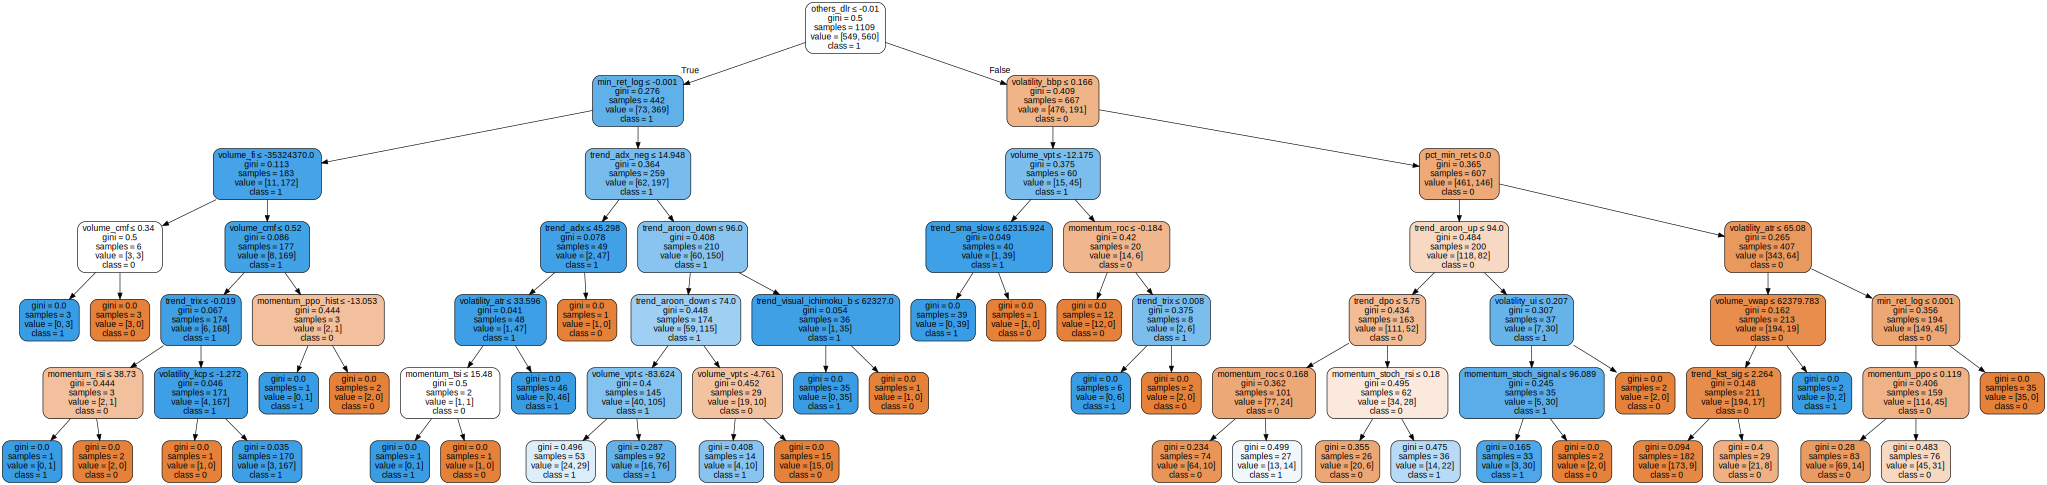

In [44]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=data.columns,  
                      class_names=['0', '1'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("../web/assets/rf") 
graph 

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
for max_depth in range (2,40):
    rf = RandomForestClassifier(n_estimators=200, max_depth=max_depth, max_leaf_nodes=100)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8594594594594595

In [35]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.12386088748504452, 'sign'),
 (0.06757629681479534, 'others_dlr'),
 (0.058375409732067694, 'pct_min_ret'),
 (0.053401502698530126, 'min_ret_log'),
 (0.052791437965488, 'others_dr'),
 (0.044381764820366716, 'returns'),
 (0.038032296293994475, 'min_retmark'),
 (0.03366521320784033, 'min_ret'),
 (0.027532622739008222, 'volume_vpt'),
 (0.020352203158132083, 'volatility_bbp'),
 (0.017899201644749917, 'range_returns'),
 (0.01747316227503558, 'trend_aroon_down'),
 (0.013986761034962896, 'trend_cci'),
 (0.012911461515415381, 'volume_em'),
 (0.012359492867594319, 'volatility_kcp'),
 (0.010948231749399778, 'momentum_stoch_rsi'),
 (0.009735452925999971, 'volatility_dcp'),
 (0.008532822922513176, 'volume_fi'),
 (0.008468976485854025, 'momentum_tsi'),
 (0.008391767500806722, 'strat_return'),
 (0.00832423978250182, 'momentum_rsi'),
 (0.00823797660857302, 'strat_cumret'),
 (0.007826407458027153, 'trend_adx_neg'),
 (0.00760968613175951, 'trend_aroon_ind'),
 (0.007576238022548325, 'momentum_stoch'),